In [1]:
#################### 这个是最终得到的关于城市的 rank-sc ###############################
#关于文档的一个数据分类
import pandas as pd
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
import matplotlib.pyplot as plt
import numpy as np
#import csv
import math
from pandas import Series,DataFrame
from matplotlib.ticker import  MultipleLocator
import pylab as pl   #画图用
from sklearn import svm
from sklearn import linear_model

In [2]:
a = np.arange(2000,2018)
pop = [str(i)+'Pop' for i in a]
investment = [str(i)+'总投资金额(M)' for i in a]
inv_times = [str(i)+'总投资次数' for i in a]
gdp = [str(i)+'GDP' for i in a]

In [3]:
data =pd.read_excel('E:/vcdata/data/ALL_Intersection.xlsx')  # 读取训练数据
city=data['City'].drop_duplicates().values
City=data['city'].drop_duplicates().values

In [4]:
from scipy.optimize import leastsq  ##引入最小二乘法算法
#需要拟合的函数func :指定函数的形状
def func(p,x):
    k,b=p
    return k*x+b

##偏差函数：x,y都是列表:这里的x,y更上面的Xi,Yi中是一一对应的
def error(p,x,y):
    return func(p,x)-y

plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题

In [5]:
##### 求残差 logy-log（kx+b）
def GuiJI(data,xl,yl,i,xname,yname):
    ###xl,yl：列名的list,xname,yname：列名,i:年份
    city=data['City'].drop_duplicates().values
    province=data['province'].values###得到省
    r=[]  ###标度率
    ###保存取完log后大于0的值
    p=[]
    g=[]
    ###取列值的log
    XI=data[xl[i]]
    YI=data[yl[i]]
    xi=np.log10(XI)
    yi=np.log10(YI)
    XII=xi.fillna(np.infty) ###将空值置为inf
    YII=yi.fillna(np.infty)
    ###判断是否大于0
    City=[]###保存log值大于0的城市名
    pro=[]###保存log值大于0的省名
    for mm in range(len(XII)):
        if XII[mm]==-float('Inf') or XII[mm]==float('Inf') or YII[mm]==-float('Inf') or YII[mm]==float('Inf'):
            continue
        else:
            p.append(XII[mm])
            g.append(YII[mm])
            City.append(city[mm])
            pro.append(province[mm])
                           
    #k,b的初始值，可以任意设定,经过几次试验，发现p0的值会影响cost的值：Para[1]
    p0=[1,10]
    Xi=np.array(p)
    Yi=np.array(g)
    #把error函数中除了p0以外的参数打包到args中(使用要求)
    Para=leastsq(error,p0,args=(Xi,Yi))## 三个参数：误差函数、函数参数列表、数据点
    #读取结果
    k,b=Para[0]
    ###将标度率写入r中
    r.append(k) 
    y = [k*x+b for x in p]
    ###得到残差
    sc=[g[v]-y[v] for v in range(len(g))]
    
    ###计算频率分布
    maxsc=max(sc)
    minsc=min(sc)
    Paragraph_len=(maxsc-minsc)/10
    fresc=[]###频率
    xvalue=[] ###坐标所在数段
    for i in range(10):
        num=0
        psc=minsc+Paragraph_len*i ###左坐标
        rpsc=psc+Paragraph_len    ###右坐标
        for scj in sc:
            if scj>=psc and scj<rpsc:
                num=num+1
        fresc.append(num/len(City))
        xvalue.append((psc+rpsc)/2)
        
    ###按照sc的值进行排序
    scdic = list(zip(sc,City))
    scSort = sorted( scdic,reverse = True)###残差城市排序
    prodic = list(zip(sc,pro))
    proSort = sorted( prodic,reverse = True)
    return(r,City,p,g,y,sc,fresc,xvalue,scSort,k,b,proSort)

In [6]:
def getCity(s):
    a=list(s.split('|'))
    return(a[1])
data['province']=data.city.map(getCity)
province=data['province'].drop_duplicates().values###得到省

In [7]:
########## 
cityM = GuiJI(data,pop,investment,15,'pop','amount')[1]###按照2015年含有投资金额的城市来删选2000-2016年间关于GDP\amount\times的数据
####查看一些城市2000-2016年的残差分布图
scall=[]###保存所有城市2000-2016年的残差
scallM=[]
scallT=[]
for i in range(18):    
    ### GDP残差
    sami=GuiJI(data,pop,gdp,i,'pop','GDP')
    sc1=sami[8]###获取某一年的残差值
#     cityname=sami[1]###城市名
    sc = np.arange(1,len(sc1)+1)
    cityname = [sc1[ii][1] for ii in range(len(sc1))]

    ###amount
    samiM=GuiJI(data,pop,investment,i,'pop','amount')
#     scM=samiM[5]###获取某一年的残差值
#     citynameM=samiM[1]###城市名
    sc2=samiM[8]###获取某一年的残差值
    scM = np.arange(1,len(sc2)+1)
    citynameM = [sc2[ii][1] for ii in range(len(sc2))]

    ###times
    samiT=GuiJI(data,pop,inv_times,i,'pop','times')
    sc3=samiT[8]###获取某一年的残差值
#     citynameT=samiT[1]###城市名
    scT = np.arange(1,len(sc3)+1)
    citynameT = [sc3[ii][1] for ii in range(len(sc3))]
 
    ### 删选出来含有投资的城市的GDP\TIMES
    sc_GDP0=[] ###保存含有投资的城市的GDP
    sc_amount0 = [] ###投资金额
    sc_times0=[] ###保存旱藕投资的城市的投资次数
    
    ### 1 得到GDP的数据
    for c1 in cityM:
        have = 0 ###标志该城市是否存在,0表示不存在
        for c2 in range(len(cityname)):
            if cityname[c2] == c1:
                sc_GDP0.append(sc[c2])
                have = 1
        if have == 0:
            sc_GDP0.append(0)
    ### 2 得到投资金额的数据
    for c1 in cityM:
        have1 = 0 ###标值该城市是否存在,0表示不存在
        for c2 in range(len(citynameM)):
            if citynameM[c2] == c1:
                sc_amount0.append(scM[c2])
                have1 = 1
        if have1 == 0:
            sc_amount0.append(0)
    ### 3 得到投资次数的残差数据
    for c1 in cityM:
        have2 = 0
        for c2 in range(len(citynameT)):
            if citynameT[c2] == c1:
                sc_times0.append(scT[c2])
                have2 = 1
        if have2 == 0:
            sc_times0.append(0)
            
    scallM.append(sc_amount0)###得到删选后的残差,城市和投资金额城市保持一致
    scallT.append(sc_times0)
    scall.append(sc_GDP0)

D:\Users\lu\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


In [8]:
rankAmount = pd.DataFrame(scallM,columns=cityM)
rankTimes = pd.DataFrame(scallT,columns=cityM)
rankGMP = pd.DataFrame(scall,columns=cityM)

In [9]:
rankAmount = rankAmount.replace([0], np.nan)
rankTimes = rankTimes.replace([0], np.nan)
rankGMP = rankGMP.replace([0], np.nan)

In [15]:
def leida(rankAmount,name,ax):
    # 用于正常显示中文
    plt.rcParams['font.sans-serif'] = 'Simhei'
    #用于正常显示符号
    plt.rcParams['axes.unicode_minus'] = False

    # 使用ggplot的绘图风格，这个类似于美化了，可以通过plt.style.available查看可选值，你会发现其它的风格真的丑。。。
    plt.style.use('ggplot')

    # 构造数据
    values = rankAmount[name]
    feature = [str(2000+i) for i in range(18)]

    # 设置每个数据点的显示位置，在雷达图上用角度表示
    angles=np.linspace(0, 2*np.pi,len(values), endpoint=False)

    # 拼接数据首尾，使图形中线条封闭
#     values=np.concatenate((values,[values[0]]))
#     angles=np.concatenate((angles,[angles[0]]))

    # 绘制折线图
    ax.plot(angles, values,  linewidth=2,color = colors[name])
    # 填充颜色
#     ax.fill(angles, values, alpha=0.15)

    # 设置图标上的角度划分刻度，为每个数据点处添加标签
    ax.set_thetagrids(angles * 180/np.pi, feature)
    plt.tick_params(labelsize=12) #刻度字体大小13
    
    ax.set_rlabel_position(340)
    ax1.grid(True)

    # 设置雷达图的范围
    # ax.set_ylim(0,5)
    # 添加标题
#     plt.title('活动前后员工状态表现')
    # 添加网格线
    
 


In [16]:
cityM[0]

'上海'

D:\Users\lu\Anaconda3\lib\site-packages\matplotlib\projections\polar.py:67: RuntimeWarning: invalid value encountered in less
  mask = r < 0


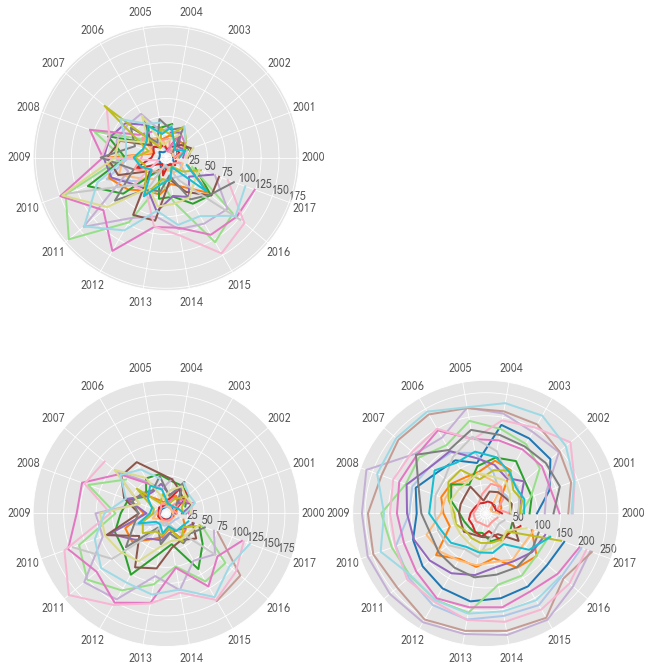

In [27]:
plt.rcParams['font.sans-serif']=['Simhei']     #解决中文显示问题，目前只知道黑体可行
plt.rcParams['axes.unicode_minus']=False       #解决负数坐标显示问题
city_big = ['北京','上海','广州','深圳','天津','石家庄','杭州','苏州','武汉','郑州',
            '青岛','邯郸','哈尔滨','太原','西安','廊坊','长沙','济南','成都','重庆']
a=plt.cm.tab20.colors
colors=dict(zip(city_big,a))
# 绘图
fig=plt.figure(figsize=(10.5,12))
    # 设置为极坐标格式
ax1 = fig.add_subplot(221, polar=True)
for c in city_big:
    leida(rankAmount,c,ax1)
ax1.grid(True)
# plt.text(-1,2,'(a)',fontsize=12)
ax2 = fig.add_subplot(223, polar=True)
for c in city_big:
    leida(rankTimes,c,ax2)
ax2.grid(True)
ax3 = fig.add_subplot(224, polar=True)
for c in city_big:
    leida(rankGMP,c,ax3)
ax3.grid(True)

# ax4 = fig.add_subplot(144)
# # plt.text(1,-1,'(d)')
# # yvalue = np.arange(1,21)
# yvalue = 0
# for c in range(len(city_big)):
#     plt.bar(x=1,width=0.1,bottom=yvalue,height=0.1,color=colors[city_big[c]])
#     plt.text(1.05,yvalue,city_big[c],fontsize=13)
#     yvalue+=0.1
# plt.axis('off')
plt.savefig('E:/0论文/2picture/71.png',dpi=500, bbox_inches='tight')    
# for 
# plt.bar(xM[cc],citySC[cc],color=yj_color[proName[cc]])

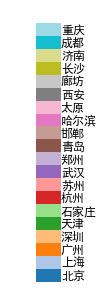

In [42]:
# ax4 = fig.add_subplot(224)
plt.figure(figsize=(0.5,5))
# yvalue = np.arange(1,21)
yvalue = 0
for c in range(len(city_big)):
    yvalue
    plt.bar(x=0,width=0.02,bottom=yvalue,height=0.1,color=colors[city_big[c]], lw=0.1)
    plt.text(0.01,yvalue+0.02,city_big[c],fontsize=12)
    yvalue += 0.1
plt.axis('off')
plt.savefig('E:/0论文/0picture/72.png',dpi=500, bbox_inches='tight') 